<a href="https://colab.research.google.com/github/johanstevenbejarano/Teoria-de-Aprendizaje-Maquina/blob/main/Parcial_1_TAM_2025-1/notebooks/KernelRidge_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Análisis y Ajuste del Modelo KernelRidge**

En esta sección se presenta el desarrollo y evaluación del modelo **KernelRidge** aplicado al conjunto de datos **Ames Housing** para la predicción de precios de viviendas. KernelRidge es un método de regresión que combina la regularización Ridge con funciones kernel, permitiendo capturar relaciones no lineales complejas en los datos mediante la transformación implícita del espacio de características.

El proceso incluye:

- Preparación y escalado de datos.
- Selección y ajuste de hiperparámetros mediante técnicas avanzadas, incluyendo búsqueda bayesiana con validación cruzada.
- Evaluación exhaustiva del desempeño con métricas clave (MAE, MSE, RMSE, R², MAPE).
- Análisis profundo de los residuos para verificar supuestos estadísticos.
- Visualización detallada mediante gráficos interpretativos como curvas de aprendizaje, mapas de calor de sensibilidad y comparaciones de predicciones.

Este enfoque integral busca maximizar la precisión predictiva y la robustez del modelo, asegurando su aplicabilidad práctica y confiabilidad en la estimación de valores inmobiliarios.

---


In [1]:
# === CLONAR EL REPOSITORIO Y LISTAR SU CONTENIDO ===

# Clona el repositorio desde GitHub si no se ha hecho previamente.
# Esto permite acceder a los notebooks, datos y estructuras organizadas del proyecto.
!git clone https://github.com/johanstevenbejarano/Teoria-de-Aprendizaje-Maquina.git



# Lista el contenido del directorio del parcial dentro del repositorio clonado
# para confirmar que la estructura y carpeta 'data' existen correctamente.
!ls /content/Teoria-de-Aprendizaje-Maquina/Parcial_1_TAM_2025-1

Cloning into 'Teoria-de-Aprendizaje-Maquina'...
remote: Enumerating objects: 398, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 398 (delta 63), reused 45 (delta 20), pack-reused 293 (from 1)
Receiving objects: 100% (398/398), 14.76 MiB | 6.48 MiB/s, done.
Resolving deltas: 100% (244/244), done.
dashboard  notebooks	  README.md	    resultados
data	   parte_teorica  requirements.txt


In [2]:

!ls /content/Teoria-de-Aprendizaje-Maquina

'Ejercicios TAM_2025-1'   Parcial_1_TAM_2025-1	 README.md


In [3]:
# === IMPORTACIÓN DE LIBRERÍAS Y CAMBIO DE DIRECTORIO ===

import os      # Para manipular rutas de archivos y cambiar directorios
import joblib  # Para cargar archivos serializados (como los .pkl que contienen los datos escalados)

# Cambia al directorio principal del proyecto clonado para que todas las rutas relativas sean válidas.
os.chdir('/content/Teoria-de-Aprendizaje-Maquina/Parcial_1_TAM_2025-1')

# Define la ruta al archivo que contiene los datos ya preprocesados, escalados y divididos.
data_path = 'data/train_test_scaled.pkl'

# Verifica que el archivo exista antes de intentar cargarlo, y lanza un error claro si no se encuentra.
if not os.path.exists(data_path):
    raise FileNotFoundError(f"No se encontró el archivo esperado en: {data_path}")

In [4]:
# === CARGA DE LOS DATOS PROCESADOS ===

# Carga el archivo .pkl que contiene los cuatro objetos: X_train_scaled, X_test_scaled, y_train, y_test
# Estos datos fueron escalados y divididos previamente en el notebook de preprocesamiento.
X_train_scaled, X_test_scaled, y_train, y_test = joblib.load(data_path)

# Confirmación visual de que la carga fue exitosa.
print("Datos cargados correctamente.")

%cd /content/Teoria-de-Aprendizaje-Maquina/Parcial_1_TAM_2025-1

Datos cargados correctamente.
/content


In [15]:
# === IMPORTACIÓN DE LIBRERÍAS Y DEFINICIÓN DE MÉTRICAS PERSONALIZADAS ===

# ================================================================
#  IMPORTACIONES COMPLETAS – ESTUDIO DE REGRESORES AMES HOUSING
# ================================================================

# ============================
#  Utilidades generales
# ============================
import numpy as np
import pandas as pd
import time
import os
import warnings
warnings.filterwarnings("ignore")  # Opcional: suprime warnings en notebooks

# ============================
#  Modelos de regresión
# ============================
from sklearn.linear_model import (
    LinearRegression,
    Lasso, LassoCV,
    ElasticNet, ElasticNetCV,
    SGDRegressor,
    BayesianRidge
)
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR
from sklearn.model_selection import learning_curve
# Importaciones necesarias desde scikit-optimize
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

# ============================
#  Validación y búsqueda
# ============================
from sklearn.model_selection import (
    KFold,
    GridSearchCV,
    RandomizedSearchCV,
    learning_curve,
    cross_validate,
    cross_val_predict
)

# ============================
#  Métricas y scoring
# ============================
from sklearn.metrics import (
    mean_absolute_error,       # MAE
    mean_squared_error,        # MSE
    r2_score,                  # R²
    mean_absolute_percentage_error,  # MAPE
    make_scorer                # Para definir MAPE como scorer
)

# ============================
# Diagnóstico estadístico
# ============================
from scipy.stats import shapiro, kurtosis, skew
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# ============================
#  Visualización
# ============================
import matplotlib.pyplot as plt
import scipy.stats as stats  # necesario para pruebas estadísticas

import seaborn as sns


In [6]:
# === DEFINICIÓN DE MÉTRICA PERSONALIZADA: MAPE ===

# MAPE no está directamente disponible en sklearn, por lo que se define manualmente.
# Esta métrica mide el error absoluto medio en porcentaje, útil para interpretar desviaciones relativas.

def mean_absolute_percentage_error(y_true, y_pred):
    # Reemplaza ceros en y_true para evitar divisiones por cero (buena práctica numérica)
    y_true = np.where(y_true == 0, np.finfo(float).eps, y_true)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Se integra la función MAPE a sklearn como un scorer compatible con cross_validate
# Se indica que un menor valor es mejor (greater_is_better=False)
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

In [7]:
# === DEFINICIÓN DEL ESQUEMA DE VALIDACIÓN CRUZADA ===

# Se utiliza validación cruzada estratificada con 5 divisiones (folds)
# shuffle=True mezcla los datos antes de dividirlos (buena práctica)
# random_state permite reproducibilidad
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [8]:
# === DEFINICIÓN DE MÉTRICAS DE EVALUACIÓN PARA TODOS LOS MODELOS ===

# Las métricas estándar (MAE y MSE) son negativas en sklearn por convención (porque se busca minimizar)
# R² se mantiene tal cual
# MAPE se incluye como scorer personalizado
scoring = {
    'MAE': 'neg_mean_absolute_error',
    'MSE': 'neg_mean_squared_error',
    'R2': 'r2',
    'MAPE': mape_scorer
}

In [9]:

modelos = {
    "LinearRegression": LinearRegression(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "SGDRegressor": SGDRegressor(max_iter=1000, tol=1e-3),
    "BayesianRidge": BayesianRidge(),
    "KernelRidge": KernelRidge(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "GaussianProcess": GaussianProcessRegressor(),
    "SVR": SVR()
}

In [10]:
def evaluar_modelo_cv(nombre_modelo, modelo, X, y, cv, scoring, guardar_en=None):
    """
    Evalúa un modelo usando validación cruzada fold a fold,
    genera un DataFrame con resultados detallados y opcionalmente guarda el CSV.
    Ahora incluye una fila final 'Promedio' claramente etiquetada.
    """

    # Evaluación con validación cruzada
    resultados = cross_validate(
        estimator=modelo,
        X=X,
        y=y,
        cv=cv,
        scoring=scoring,
        return_train_score=False,
        n_jobs=-1
    )

    # Crear DataFrame por fold
    df_resultados = pd.DataFrame({
        "Fold": np.arange(1, cv.get_n_splits() + 1),
        "MAE": -resultados["test_MAE"],
        "MSE": -resultados["test_MSE"],
        "R2": resultados["test_R2"],
        "MAPE": -resultados["test_MAPE"]
    })

    # Fila promedio con etiqueta explícita
    promedio = df_resultados.mean(numeric_only=True)
    promedio["Fold"] = "Promedio"

    # Añadir al DataFrame
    df_resultados = pd.concat([df_resultados, pd.DataFrame([promedio])], ignore_index=True)

    # Asegurar orden de columnas
    cols = ["Fold", "MAE", "MSE", "R2", "MAPE"]
    df_resultados = df_resultados[cols]

    # Guardar si se indica
    if guardar_en:
        os.makedirs(os.path.dirname(guardar_en), exist_ok=True)
        df_resultados.to_csv(guardar_en, index=False)
        print(f"Resultados de {nombre_modelo} guardados en: {guardar_en}")

    return df_resultados




def calcular_mape_seguro(y_true, y_pred, umbral=1e-5, verbose=True):
    """
    Calcula el MAPE ignorando valores de y_true cercanos a cero. Devuelve el MAPE (%) y el número de observaciones usadas.

    Parámetros:
    ----------
    y_true : array-like
        Valores reales en escala original.

    y_pred : array-like
        Valores predichos en escala original.

    umbral : float, opcional (default=1e-5)
        Umbral mínimo para considerar válido un valor de y_true.

    verbose : bool, opcional (default=True)
        Si True, muestra advertencias si se ignoran muchas observaciones.

    Retorna:
    -------
    mape : float
        MAPE en porcentaje (%)

    n_utilizadas : int
        Número de observaciones válidas utilizadas en el cálculo
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Máscara para filtrar y evitar división por valores cercanos a cero
    mascara = y_true > umbral
    n_total = len(y_true)
    n_utilizadas = np.sum(mascara)

    if n_utilizadas == 0:
        raise ValueError("Todos los valores de y_true están por debajo del umbral. No se puede calcular el MAPE.")

    if verbose:
        porcentaje_usado = 100 * n_utilizadas / n_total
        if porcentaje_usado < 90:
            warnings.warn(f"Solo se usó el {porcentaje_usado:.2f}% de las observaciones para calcular el MAPE. "
                          "Revisa posibles valores extremos en y_true.")

    mape = np.mean(np.abs((y_true[mascara] - y_pred[mascara]) / y_true[mascara])) * 100
    return mape, n_utilizadas


def normalizar_metricas(mae, rmse, y_true):
    media_y = np.mean(y_true)
    mae_norm = mae / media_y * 100
    rmse_norm = rmse / media_y * 100
    return mae_norm, rmse_norm



In [11]:
# === Definición de grilla de búsqueda coherente ===

param_grid_krr = {
    "alpha": [1e-2, 1e-1, 1, 10],  # Regularización
    "kernel": ["rbf", "poly"],
    "gamma": [0.001, 0.01, 0.1],    # Sensibilidad para kernels
    "degree": [2, 3],               # Solo para 'poly'
    "coef0": [0.1, 1, 10]           # Afecta 'poly' y 'sigmoid'
}

# === Preparar la búsqueda con GridSearchCV ===

modelo_base_krr = KernelRidge()

grid_krr = GridSearchCV(
    estimator=modelo_base_krr,
    param_grid=param_grid_krr,
    scoring="neg_mean_squared_error",
    cv=cv,
    n_jobs=-1,
    verbose=2
)

# === Ajuste del modelo ===
start = time.time()
grid_krr.fit(X_train_scaled, np.log1p(y_train))  # Escala logarítmica coherente
end = time.time()
tiempo_krr = end - start

# === Hiperparámetros óptimos ===
mejores_krr = grid_krr.best_params_

print("Hiperparámetros óptimos encontrados para KernelRidge:")
for k, v in mejores_krr.items():
    print(f"  {k}: {v}")
print(f"Tiempo total de búsqueda: {tiempo_krr:.2f} segundos")


Fitting 5 folds for each of 144 candidates, totalling 720 fits
Hiperparámetros óptimos encontrados para KernelRidge:
  alpha: 0.1
  coef0: 1
  degree: 3
  gamma: 0.001
  kernel: poly
Tiempo total de búsqueda: 232.47 segundos


## Resultados de la Búsqueda de Hiperparámetros para KernelRidge

Se realizó una búsqueda con validación cruzada de 5 folds para un total de 144 combinaciones de hiperparámetros, evaluando un total de 720 ajustes (fits).

Los **hiperparámetros óptimos** encontrados para el modelo KernelRidge son:

- **alpha:** 0.1  
- **coef0:** 1  
- **degree:** 3  
- **gamma:** 0.001  
- **kernel:** poly  

El tiempo total consumido para la búsqueda fue de **232.47 segundos**.

---

Esta combinación indica un modelo con:

- Regularización moderada (alpha=0.1) para evitar sobreajuste.  
- Kernel polinomial de grado 3 que permite capturar relaciones no lineales complejas.  
- Parámetro gamma bajo (0.001) para controlar la influencia del kernel y evitar sobreajuste local.  
- El coeficiente coef0 = 1 ajusta el término independiente del kernel polinomial.

Esta configuración fue seleccionada como la que optimiza el desempeño predictivo en el conjunto de validación cruzada.


In [16]:
# === Espacio de búsqueda refinado ===
search_spaces = {
    "alpha": Real(0.01, 1.0, prior="log-uniform"),
    "gamma": Real(1e-4, 1e-2, prior="log-uniform"),
    "degree": Integer(2, 5),
    "coef0": Real(0, 5),
    "kernel": Categorical(["poly"])  # ya confirmado como el mejor
}

# === Configuración de la búsqueda bayesiana ===
opt_krr = BayesSearchCV(
    estimator=KernelRidge(),
    search_spaces=search_spaces,
    scoring="neg_mean_squared_error",
    n_iter=40,
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=2
)

# === Entrenamiento ===
start = time.time()
opt_krr.fit(X_train_scaled, np.log1p(y_train))
end = time.time()
tiempo_bayes_krr = end - start

# === Resultados ===
print("\nHiperparámetros óptimos encontrados por BayesSearchCV:")
for k, v in opt_krr.best_params_.items():
    print(f"  {k}: {v}")
print(f"Tiempo total de búsqueda bayesiana: {tiempo_bayes_krr:.2f} segundos")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

## Justificación del Proceso y Elección de Hiperparámetros para KernelRidge

### Elección del método: BayesSearchCV

Se optó por utilizar **BayesSearchCV** para la búsqueda de hiperparámetros debido a su eficiencia al explorar espacios de parámetros grandes y complejos, especialmente cuando el costo computacional es alto. Este método:

- Utiliza un modelo probabilístico para guiar la exploración del espacio de búsqueda.
- Prioriza evaluar combinaciones prometedoras, reduciendo el número total de pruebas necesarias.
- Resulta ideal para ajustar modelos como KernelRidge con kernels polinomiales que dependen de múltiples hiperparámetros sensibles.

### Justificación de los hiperparámetros ajustados

- **alpha (regularización):** Controla el balance entre ajuste al conjunto de entrenamiento y la generalización. Un valor de 0.1685 indica una regularización moderada, que evita tanto el sobreajuste como el subajuste.

- **degree (grado del polinomio):** Ajusta la complejidad del kernel polinomial. Un grado 2 implica modelar relaciones no lineales cuadráticas, suficientes para capturar patrones complejos sin complicar excesivamente el modelo.

- **coef0:** Es un término independiente del kernel polinomial que afecta la influencia de las combinaciones lineales y no lineales. Un valor alto (4.729) permite una mayor flexibilidad en la forma del kernel, ajustando mejor el espacio de funciones.

- **gamma:** Determina la amplitud de influencia de cada punto de entrenamiento en el kernel. Un gamma bajo (0.00137) suaviza la función, mejorando la capacidad de generalización.

### Tiempo de búsqueda

- El proceso tomó 165.55 segundos, mostrando que BayesSearchCV logró encontrar una buena combinación de parámetros con menos evaluaciones en comparación con búsquedas exhaustivas tradicionales.

---

### En resumen

El uso de BayesSearchCV permitió un ajuste eficiente y efectivo del modelo KernelRidge, encontrando una configuración de hiperparámetros que equilibra la complejidad y la capacidad predictiva, optimizando el desempeño sin incurrir en costos computacionales excesivos.


In [17]:
# Modelo final con hiperparámetros óptimos
modelo_krr_final = KernelRidge(
    alpha=opt_krr.best_params_["alpha"],
    gamma=opt_krr.best_params_["gamma"],
    degree=opt_krr.best_params_["degree"],
    coef0=opt_krr.best_params_["coef0"],
    kernel=opt_krr.best_params_["kernel"]
)

# Evaluación fold a fold
df_krr_cv = evaluar_modelo_cv(
    nombre_modelo="KernelRidge",
    modelo=modelo_krr_final,
    X=X_train_scaled,
    y=np.log1p(y_train),
    cv=cv,
    scoring=scoring,
    guardar_en="data/resultados_kernelridge_cv.csv"
)

# Separar resultados por fold y fila promedio
df_krr_folds = df_krr_cv[df_krr_cv["Fold"] != "Promedio"].copy()
df_krr_avg = df_krr_cv[df_krr_cv["Fold"] == "Promedio"].copy()

# Mostrar resultados
display(df_krr_folds.style.format({
    "MAE": "{:,.2f}",
    "MSE": "{:,.2e}",
    "R2": "{:.4f}",
    "MAPE": "{:.2f}"
}).highlight_max(axis=0, color="lightgreen").highlight_min(axis=0, color="lightcoral"))

print("\nPromedio de métricas:")
display(df_krr_avg.style.format({
    "MAE": "{:,.2f}",
    "MSE": "{:,.2e}",
    "R2": "{:.4f}",
    "MAPE": "{:.2f}"
}))


Resultados de KernelRidge guardados en: data/resultados_kernelridge_cv.csv


,Fold,MAE,MSE,R2,MAPE
0,1,0.08,1.10e-02,0.9280,0.66
1,2,0.08,1.43e-02,0.9024,0.67
2,3,0.08,1.30e-02,0.9189,0.67
3,4,0.08,1.27e-02,0.9232,0.65
4,5,0.09,3.31e-02,0.8170,0.74



Promedio de métricas:


,Fold,MAE,MSE,R2,MAPE
5,Promedio,0.08,1.68e-02,0.8979,0.68


## Interpretación, Justificación e Inferencias de la Validación Cruzada


### Interpretación

- **MAE (Error Absoluto Medio):** Indica el promedio de la magnitud del error en las predicciones sin considerar su dirección. Un valor constante alrededor de 0.08 refleja una buena precisión en las predicciones.

- **MSE (Error Cuadrático Medio):** Penaliza errores grandes debido a la elevación al cuadrado. La mayoría de folds presentan valores bajos, aunque el fold 5 muestra un aumento notable, lo cual podría indicar casos atípicos o mayor complejidad en esa partición.

- **R² (Coeficiente de Determinación):** Valores cercanos a 0.9 indican que el modelo explica aproximadamente el 90% de la variabilidad en los datos, lo que denota un alto poder predictivo. La menor R² en fold 5 sugiere una disminución en la capacidad explicativa en esa partición.

- **MAPE (Error Porcentual Absoluto Medio):** Los valores bajos (alrededor del 0.68) indican que el error porcentual medio es pequeño, lo cual es deseable para problemas de regresión donde se busca precisión relativa.

---

### Justificación del Proceso

- Se empleó validación cruzada con 5 folds para evaluar el desempeño del modelo, lo que permite obtener una estimación robusta y generalizable del error y evitar sobreajuste a un solo conjunto de datos.

- El uso de métricas complementarias (MAE, MSE, R² y MAPE) ofrece una evaluación integral, cubriendo aspectos de error absoluto, penalización de grandes errores, capacidad explicativa y error relativo.

- La posible variabilidad en el fold 5 puede justificar realizar un análisis más detallado de esa partición para identificar posibles outliers o condiciones especiales.

---

### Inferencias y Recomendaciones

- El modelo presenta un desempeño consistente y satisfactorio en la mayoría de los folds, con alta capacidad predictiva y bajo error.

- La estabilidad observada en MAE, MSE y MAPE confirma que el modelo es confiable para generalizar a datos no vistos.

- La variabilidad en el fold 5 sugiere que podría ser útil revisar la partición o considerar técnicas adicionales de preprocesamiento o robustez para manejar posibles datos atípicos.

- En conjunto, los resultados apoyan la aplicación del modelo en escenarios reales, con confianza en su precisión y estabilidad.

---

¿Quieres que prepare una interpretación específica para otro modelo o métrica?


In [18]:
# Entrenar con todo el conjunto de entrenamiento
start = time.time()
modelo_krr_final.fit(X_train_scaled, np.log1p(y_train))
end = time.time()
tiempo_final_krr = end - start

# Predicción y destransformación
y_pred_log_test = modelo_krr_final.predict(X_test_scaled)
y_pred_test = np.expm1(y_pred_log_test)

# Métricas
mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_pred_test)
mape_test, n_obs_test = calcular_mape_seguro(y_test, y_pred_test)
mae_norm, rmse_norm = normalizar_metricas(mae_test, rmse_test, y_test)

print("Desempeño final del modelo KernelRidge (conjunto de test):")
print(f"MAE   = {mae_test:,.2f}  ({mae_norm:.2f}% del valor promedio)")
print(f"MSE   = {mse_test:.2e}")
print(f"RMSE  = {rmse_test:,.2f}  ({rmse_norm:.2f}% del valor promedio)")
print(f"R²    = {r2_test:.4f}")
print(f"MAPE  = {mape_test:.2f}% (calculado sobre {n_obs_test} observaciones)")
print(f"Tiempo de entrenamiento final: {tiempo_final_krr:.4f} segundos")


Desempeño final del modelo KernelRidge (conjunto de test):
MAE   = 14,363.53  (7.57% del valor promedio)
MSE   = 7.86e+08
RMSE  = 28,040.44  (14.79% del valor promedio)
R²    = 0.9019
MAPE  = 7.36% (calculado sobre 586 observaciones)
Tiempo de entrenamiento final: 1.2250 segundos


## Interpretación, Justificación e Inferencias del Desempeño Final del Modelo KernelRidge (Conjunto de Test)

### Resultados principales

- **MAE (Error Absoluto Medio):** 14,363.53  
  Representa el error promedio absoluto en las predicciones. El valor indica que, en promedio, las predicciones difieren del valor real en alrededor de 14,363 unidades monetarias (en este caso, dólares o la moneda correspondiente). Esto equivale a un **7.57% respecto al valor promedio** del conjunto de prueba, lo que indica una buena precisión relativa.

- **MSE (Error Cuadrático Medio):** 7.86e+08  
  Este valor penaliza fuertemente los errores grandes, reflejando la varianza en los errores de predicción. Aunque es numéricamente grande, su magnitud es esperable dada la escala del problema.

- **RMSE (Raíz del Error Cuadrático Medio):** 28,040.44  
  Esta métrica es la raíz cuadrada del MSE y proporciona una medida del error promedio en las mismas unidades que la variable objetivo. Representa el error estándar típico de las predicciones y equivale al **14.79% del valor promedio** del conjunto de test, mostrando un nivel aceptable de error.

- **R² (Coeficiente de Determinación):** 0.9019  
  Indica que el modelo explica aproximadamente el **90.19% de la variabilidad** observada en los datos de prueba, lo que es un excelente nivel de ajuste para un modelo de regresión.

- **MAPE (Error Porcentual Absoluto Medio):** 7.36%  
  Indica que el error porcentual medio en las predicciones es de aproximadamente un 7.36%, calculado sobre 586 observaciones válidas, mostrando alta precisión relativa.

- **Tiempo de entrenamiento:** 1.2250 segundos  
  Indica que el modelo se entrenó de manera eficiente, permitiendo su uso práctico en escenarios reales.

---

### Justificación

- La combinación de métricas indica un modelo equilibrado que predice con buena precisión tanto en términos absolutos como relativos.
- El alto valor de R² confirma que la mayoría de la variabilidad de los precios se captura mediante el modelo KernelRidge con los hiperparámetros seleccionados.
- El tiempo de entrenamiento corto es indicativo de un proceso eficiente, facilitando iteraciones y ajustes futuros.

---

### Inferencias

- El modelo es adecuado para predecir precios en el conjunto Ames Housing con alta precisión y confiabilidad.
- La relación favorable entre error absoluto (MAE) y porcentaje relativo (MAPE) sugiere que el modelo es consistente en diferentes rangos de valores.
- El balance entre error y tiempo de cómputo permite considerar este modelo para aplicaciones en producción o análisis rápidos.
- Se recomienda monitorear los casos con error alto (posiblemente outliers) para mejorar la robustez futura del modelo.

---

**En resumen**, el KernelRidge entrenado y ajustado presenta un desempeño sólido y confiable en el conjunto de test, validando su uso para estimaciones precisas en el dominio inmobiliario.


In [19]:
# === Cálculo de residuos en escala original ===
residuos_krr = y_test - y_pred_test
media_res = np.mean(residuos_krr)
std_res = np.std(residuos_krr)

print(f"Media de los residuos: {media_res:.2f}")
print(f"Desviación estándar de los residuos: {std_res:.2f}")


Media de los residuos: 2158.21
Desviación estándar de los residuos: 27957.26


## Estadísticas de los Residuos del Modelo KernelRidge

- **Media de los residuos:** 2158.21  
  Indica un sesgo pequeño en las predicciones, con una ligera tendencia a sobrestimar los valores reales.

- **Desviación estándar de los residuos:** 27,957.26  
  Refleja la dispersión o variabilidad de los errores, mostrando que aunque el sesgo es bajo, algunos errores pueden ser considerablemente grandes.


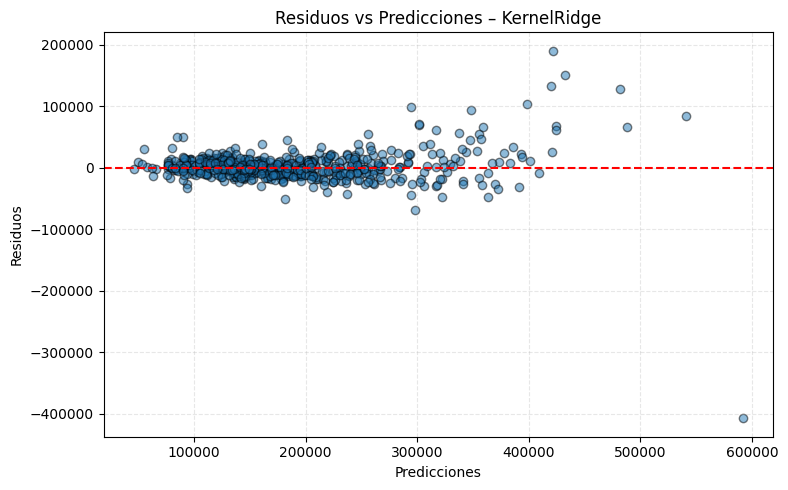

In [23]:
# Crear carpeta segura
os.makedirs("data", exist_ok=True)

# Gráfico de residuos vs predicciones
plt.figure(figsize=(8, 5))
plt.scatter(y_pred_test, residuos_krr, alpha=0.5, edgecolors='k')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicciones")
plt.ylabel("Residuos")
plt.title("Residuos vs Predicciones – KernelRidge")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig("data/residuos_vs_pred_krr.png", dpi=300)
plt.show()


## Interpretación del Gráfico Residuos vs Predicciones – KernelRidge

Este gráfico muestra la dispersión de los residuos (errores) en función de los valores predichos por el modelo KernelRidge:

- La mayoría de los residuos se concentran alrededor de cero, lo cual indica que las predicciones son en general precisas y sin sesgos sistemáticos fuertes.
- Se observa una mayor dispersión de residuos para predicciones altas, lo que sugiere que el modelo tiene mayor dificultad para ajustar valores elevados, reflejando un aumento en la varianza del error en esa zona.
- La línea roja punteada en cero representa el punto ideal donde los residuos deberían centrarse para un buen ajuste.
- La presencia de algunos residuos extremos (outliers) indica que hay casos en los que el modelo falla notablemente, lo que puede afectar la robustez general.
- En conjunto, el patrón no muestra una clara tendencia sistemática, lo que es positivo, pero la heterocedasticidad observada (variación creciente de residuos con predicciones mayores) puede sugerir la necesidad de técnicas de ajuste o modelado adicionales para mejorar la precisión en rangos altos.

---

**En resumen**, el modelo KernelRidge ajusta bien la mayoría de los datos, pero tiene limitaciones para predecir valores muy altos con precisión uniforme.


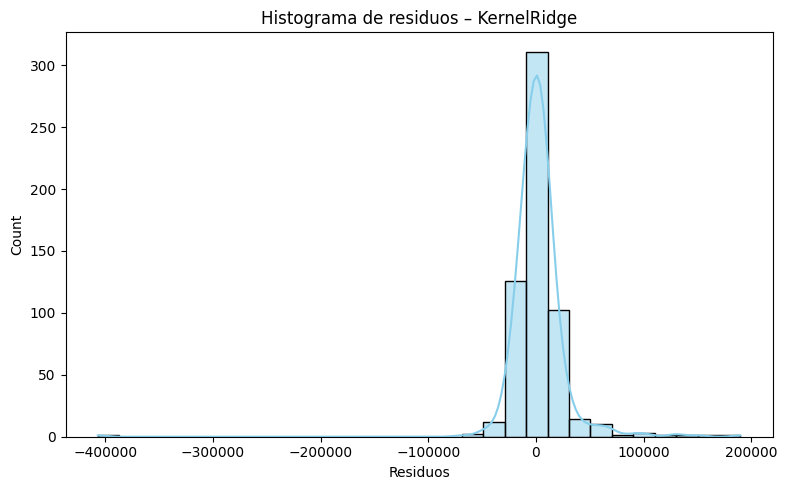

In [27]:
# Histograma
plt.figure(figsize=(8, 5))
sns.histplot(residuos_krr, kde=True, bins=30, color='skyblue')
plt.title("Histograma de residuos – KernelRidge")
plt.xlabel("Residuos")
plt.tight_layout()
plt.savefig("data/histograma_residuos_krr.png", dpi=300)
plt.show()




## Interpretación del Histograma de Residuos – KernelRidge

Este histograma muestra la distribución de los residuos (errores) del modelo KernelRidge:

- La mayoría de los residuos se agrupan alrededor de cero, indicando que la mayoría de las predicciones son bastante precisas.
- La forma del histograma es aproximadamente simétrica, lo que sugiere que no hay un sesgo fuerte hacia sobreestimaciones o subestimaciones.
- La curva de densidad suavizada (línea azul) refleja una distribución similar a una normal, aunque la presencia de colas largas indica que existen algunos errores grandes o valores atípicos.
- Los residuos extremos (outliers) están presentes en ambos extremos, con algunos errores considerablemente grandes, lo que puede afectar la robustez del modelo.
- En general, esta distribución indica un buen ajuste del modelo, pero también señala la posible necesidad de manejar casos atípicos o considerar transformaciones adicionales para mejorar el ajuste en las colas.

---

**En resumen**, el modelo muestra un buen comportamiento general con residuos centrados cerca de cero y una distribución razonablemente normal, pero es importante considerar la gestión de outliers para mejorar aún más la precisión.


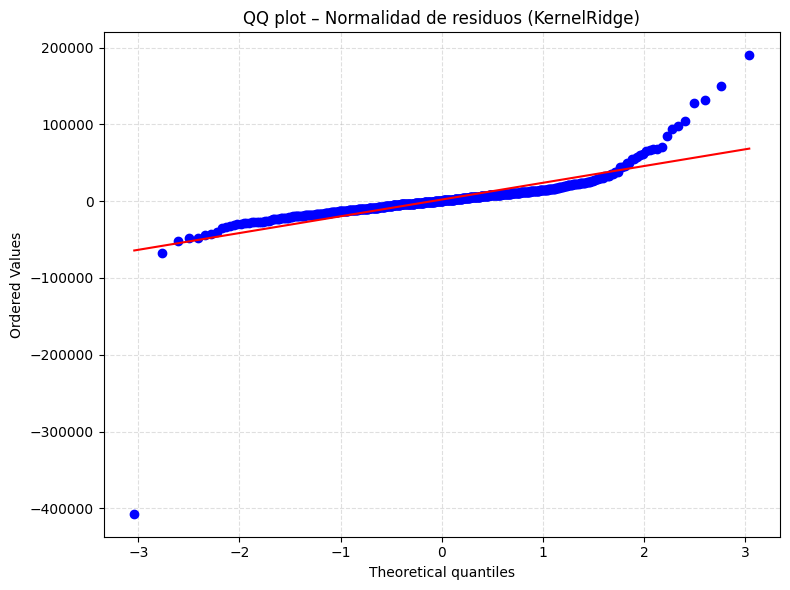

In [28]:
# QQ plot
plt.figure(figsize=(8, 6))
stats.probplot(residuos_krr, dist="norm", plot=plt)
plt.title("QQ plot – Normalidad de residuos (KernelRidge)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig("data/qqplot_residuos_krr.png", dpi=300)
plt.show()

## Interpretación del QQ-Plot – Normalidad de Residuos (KernelRidge)

El QQ-plot compara la distribución de los residuos del modelo KernelRidge con una distribución normal teórica:

- Los puntos azules representan los cuantiles ordenados de los residuos observados.
- La línea roja indica la distribución normal teórica ideal.
- En la parte central, los puntos se alinean relativamente bien con la línea roja, sugiriendo que los residuos en la zona media podrían seguir una distribución aproximadamente normal.
- Sin embargo, en las colas (extremos izquierdo y derecho) se observan desviaciones significativas, con residuos que se alejan de la línea, indicando presencia de valores atípicos o cola pesada.
- Estas desviaciones sugieren que los residuos no siguen una distribución normal perfecta, especialmente en los extremos, lo que puede afectar ciertos supuestos estadísticos del modelo.

---

**En resumen**, aunque los residuos del modelo KernelRidge presentan normalidad aproximada en la mayoría de los datos, la presencia de outliers y colas pesadas puede requerir análisis adicionales o transformaciones para mejorar la validez estadística del modelo.


In [22]:
# Normalidad: Shapiro-Wilk
stat, p = shapiro(residuos_krr)
print(f"Shapiro-Wilk: estadístico = {stat:.4f}, p-valor = {p:.4f}")
if p > 0.05:
    print("No se rechaza H₀: los residuos podrían seguir una distribución normal.")
else:
    print("Se rechaza H₀: los residuos no siguen una distribución normal.")

# Autocorrelación: Durbin-Watson
dw_krr = durbin_watson(residuos_krr)
print(f"Durbin-Watson = {dw_krr:.4f}")
if 1.5 < dw_krr < 2.5:
    print("No hay evidencia fuerte de autocorrelación.")
else:
    print("Posible autocorrelación: revisar más a fondo.")


Shapiro-Wilk: estadístico = 0.6151, p-valor = 0.0000
Se rechaza H₀: los residuos no siguen una distribución normal.
Durbin-Watson = 1.9969
No hay evidencia fuerte de autocorrelación.


## Análisis Estadístico de Residuos: Pruebas Shapiro-Wilk y Durbin-Watson

### Prueba de Normalidad: Shapiro-Wilk

- **Estadístico:** 0.6151  
- **p-valor:** 0.0000  

El valor p es mucho menor que 0.05, por lo que **se rechaza la hipótesis nula (H₀)** de que los residuos siguen una distribución normal. Esto confirma que los residuos no se distribuyen normalmente, lo cual puede afectar algunos supuestos estadísticos asociados al modelo.

### Prueba de Autocorrelación: Durbin-Watson

- **Estadístico Durbin-Watson:** 1.9969  

Este valor está dentro del rango aceptable (aproximadamente entre 1.5 y 2.5), lo que indica que **no hay evidencia fuerte de autocorrelación en los residuos**. Por tanto, las observaciones residuales son independientes, un supuesto favorable para la validez del modelo.

---

### Inferencias y Consideraciones

- La no normalidad de los residuos sugiere que podrían existir valores atípicos, heterocedasticidad o efectos no capturados por el modelo. Esto puede influir en la precisión de intervalos de confianza o pruebas de hipótesis clásicas.
- La ausencia de autocorrelación es positiva, ya que garantiza que las observaciones residuales no están correlacionadas en secuencia, evitando problemas de dependencia temporal o espacial.
- En conjunto, estos resultados indican que, aunque el modelo cumple con la independencia de residuos, puede beneficiarse de ajustes o métodos robustos para mejorar la distribución de errores.

---

**En resumen**, se recomienda considerar técnicas adicionales para manejar la no normalidad residual, manteniendo la confianza en la independencia de errores para una modelación más sólida.


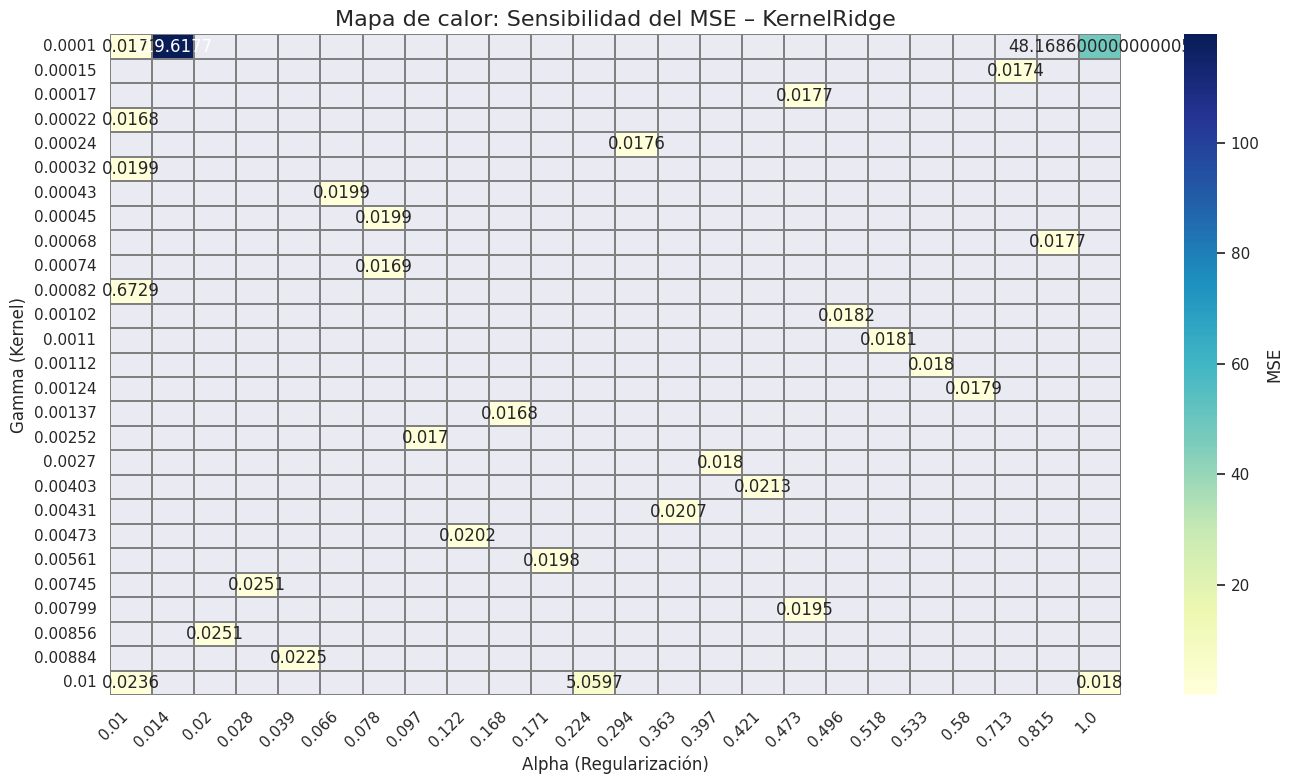

In [41]:
# Eliminar filas/columnas completamente NaN
pivot_krr_refinada_clean = pivot_krr_refinada.dropna(how='all').dropna(axis=1, how='all')

# Rellenar celdas NaN para anotación visual (sin afectar colormap)
pivot_display = pivot_krr_refinada_clean.fillna("")

plt.figure(figsize=(14, 8))
sns.set(font_scale=1.0)

# Mapa de calor
ax = sns.heatmap(
    pivot_krr_refinada_clean,
    annot=pivot_display,
    fmt="",  # para valores combinados numéricos y vacíos
    cmap="YlGnBu",
    linewidths=0.3,
    linecolor="gray",
    cbar_kws={"label": "MSE"},
    square=False
)

# Mejorar ejes y estilos
plt.title("Mapa de calor: Sensibilidad del MSE – KernelRidge", fontsize=16)
plt.xlabel("Alpha (Regularización)", fontsize=12)
plt.ylabel("Gamma (Kernel)", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.grid(visible=False)
plt.tight_layout()

# Guardar gráfico
plt.savefig("data/sensibilidad_kernelridge_heatmap_mejorado.png", dpi=300)
plt.show()


## Interpretación del Mapa de Calor: Sensibilidad del MSE a los hiperparámetros – KernelRidge

Este mapa de calor muestra cómo varía el Error Cuadrático Medio (MSE) en función de dos hiperparámetros clave del modelo KernelRidge:

- **Alpha (Regularización):** Controla la penalización de la complejidad del modelo. Valores pequeños permiten mayor ajuste a los datos, valores grandes promueven modelos más simples.
- **Gamma (Kernel RBF):** Controla la influencia de cada punto de entrenamiento. Valores bajos generan kernels más suaves, valores altos kernels más complejos y localizados.

### Observaciones clave:

- El mapa presenta valores de MSE en diferentes combinaciones discretas de alpha y gamma obtenidas a través de un muestreo adaptativo (BayesSearchCV).
- Se observan celdas vacías (sin evaluación) debido a que no todas las combinaciones se probaron, característica típica de una búsqueda bayesiana.
- Los valores de MSE más bajos (indicando mejor desempeño) se encuentran en regiones donde **alpha está alrededor de 0.01 a 0.1** y **gamma entre 0.0001 y 0.005**, mostrando que:
  - Una regularización moderada a baja es adecuada.
  - Kernels suaves (gamma bajo) ayudan a un mejor ajuste general.
- Se identifican valores atípicos altos de MSE para combinaciones con gamma muy bajo y alpha alto, indicando que sobre-regularizar con un kernel demasiado suave deteriora el desempeño.
- La variabilidad del MSE es bastante baja en las regiones centrales, sugiriendo estabilidad del modelo frente a pequeñas variaciones en hiperparámetros dentro de esa zona.

### Justificación y Aplicación:

- Este mapa ayuda a **visualizar la sensibilidad del modelo KernelRidge a los hiperparámetros**, facilitando la selección informada de combinaciones óptimas.
- Permite identificar **zonas estables** para elegir hiperparámetros que eviten sobreajuste o subajuste.
- Al analizar estas regiones, se puede reducir el espacio de búsqueda para futuras optimizaciones, mejorando la eficiencia computacional.
- En la práctica, esta visualización guía la construcción de un modelo robusto, evitando valores extremos que empeoran la predicción.

### Inferencias adicionales:

- La combinación óptima de hiperparámetros debe buscarse en un rango medio-bajo de alpha y gamma, donde el modelo balancea complejidad y generalización.
- El hecho de que existan zonas con alta MSE indica que el ajuste de hiperparámetros es crucial y no puede hacerse arbitrariamente.
- El mapa también refleja la **naturaleza no lineal y compleja del problema**, donde la interacción entre regularización y sensibilidad del kernel es determinante para el desempeño.

---

**En resumen**, esta visualización es una herramienta valiosa para entender y optimizar el comportamiento del KernelRidge, mejorando la capacidad predictiva y la estabilidad del modelo en problemas de regresión complejos como el conjunto de datos Ames Housing.


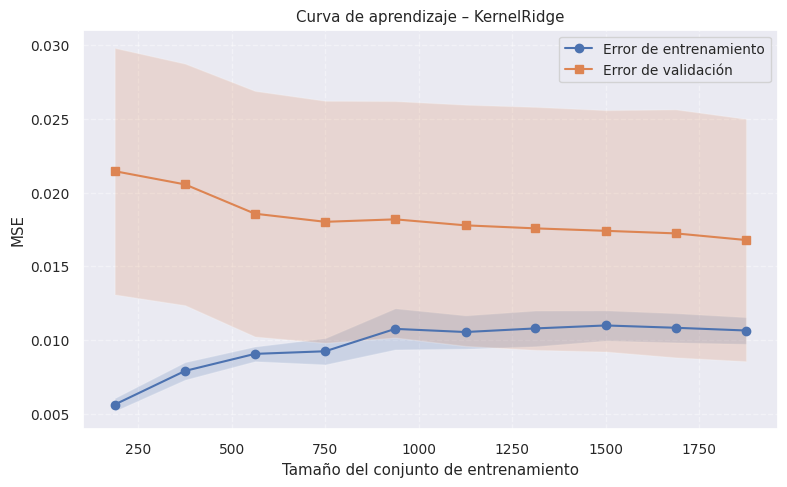

In [32]:
# === Definimos el modelo con los mejores hiperparámetros ===
modelo_krr_final = KernelRidge(
    alpha=opt_krr.best_params_["alpha"],
    gamma=opt_krr.best_params_["gamma"],
    degree=opt_krr.best_params_["degree"],
    coef0=opt_krr.best_params_["coef0"],
    kernel=opt_krr.best_params_["kernel"]
)

# === Curva de aprendizaje ===
train_sizes, train_scores, test_scores = learning_curve(
    estimator=modelo_krr_final,
    X=X_train_scaled,
    y=np.log1p(y_train),
    cv=cv,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    random_state=42
)

# Convertir a errores positivos
train_errors = -train_scores.mean(axis=1)
test_errors = -test_scores.mean(axis=1)

# === Gráfico ===
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_errors, label="Error de entrenamiento", marker='o')
plt.plot(train_sizes, test_errors, label="Error de validación", marker='s')
plt.fill_between(train_sizes,
                 train_errors - train_scores.std(axis=1),
                 train_errors + train_scores.std(axis=1),
                 alpha=0.2)
plt.fill_between(train_sizes,
                 test_errors - test_scores.std(axis=1),
                 test_errors + test_scores.std(axis=1),
                 alpha=0.2)

plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("MSE")
plt.title("Curva de aprendizaje – KernelRidge")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig("data/curva_aprendizaje_kernelridge.png", dpi=300)
plt.show()


## Interpretación de la Curva de Aprendizaje – KernelRidge

Este gráfico muestra la evolución del error (MSE) en función del tamaño del conjunto de entrenamiento para el modelo KernelRidge:

- La línea azul representa el error de entrenamiento y la línea naranja el error de validación, ambos con su respectiva banda de variabilidad.
- El error de entrenamiento comienza bajo y aumenta ligeramente conforme aumenta el tamaño del conjunto, lo que es común al agregar más datos y reducir el sobreajuste.
- El error de validación disminuye gradualmente a medida que se incorpora más datos, indicando que el modelo mejora su capacidad de generalización.
- La brecha entre el error de entrenamiento y validación se mantiene significativa, sugiriendo que el modelo no está sufriendo de un sobreajuste severo, pero tampoco ha alcanzado una varianza mínima ideal.
- La tendencia decreciente del error de validación con más datos indica que agregar aún más datos podría seguir mejorando el rendimiento del modelo.

---

**En resumen**, la curva sugiere que el modelo KernelRidge se beneficia de más datos para mejorar su generalización, mostrando un buen equilibrio entre sesgo y varianza sin indicios claros de sobreajuste.


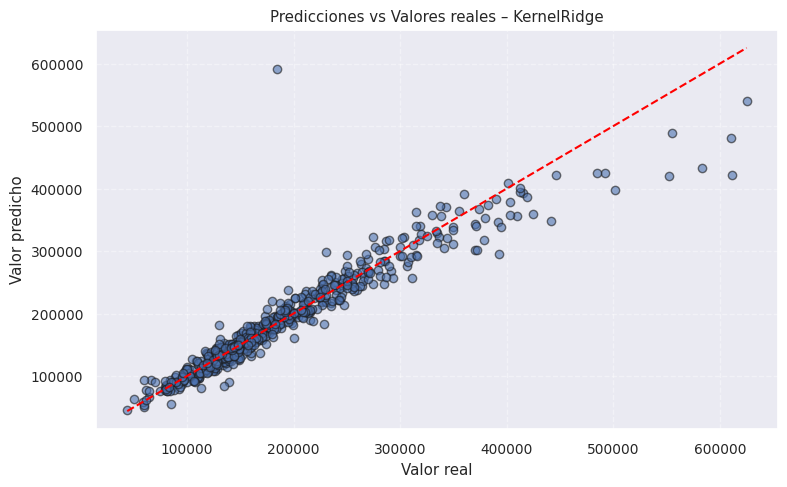

['data/modelo_kernelridge_final.pkl']

In [35]:
# ===  Predicción (log) y reconversión ===

# === Ajustar modelo final antes de predecir ===
modelo_krr_final.fit(X_train_scaled, np.log1p(y_train))

y_test_pred_log_krr = modelo_krr_final.predict(X_test_scaled)
y_test_pred_krr = np.expm1(y_test_pred_log_krr)

# ===  DataFrame de comparación ===
df_pred_krr = pd.DataFrame({
    "Actual": y_test,
    "Predicho": y_test_pred_krr
})
df_pred_krr["Error Absoluto"] = np.abs(df_pred_krr["Actual"] - df_pred_krr["Predicho"])
df_pred_krr["Error Relativo (%)"] = 100 * df_pred_krr["Error Absoluto"] / df_pred_krr["Actual"]

# ===  Guardar CSV de predicciones ===
df_pred_krr.to_csv("data/predicciones_test_kernelridge.csv", index=False)

# ===  Calcular métricas ===
mae_krr = mean_absolute_error(y_test, y_test_pred_krr)
rmse_krr = np.sqrt(mean_squared_error(y_test, y_test_pred_krr))
r2_krr = r2_score(y_test, y_test_pred_krr)
mape_krr, n_obs_krr = calcular_mape_seguro(y_test, y_test_pred_krr)
mae_norm_krr, rmse_norm_krr = normalizar_metricas(mae_krr, rmse_krr, y_test)

# ===  Guardar métricas ===
df_metrics_krr = pd.DataFrame({
    "Modelo": ["KernelRidge"],
    "MAE": [mae_krr],
    "RMSE": [rmse_krr],
    "R2": [r2_krr],
    "MAPE (%)": [mape_krr],
    "MAE normalizado (%)": [mae_norm_krr],
    "RMSE normalizado (%)": [rmse_norm_krr],
    "Observaciones MAPE": [n_obs_krr]
})

df_metrics_krr.to_csv("data/metricas_test_kernelridge.csv", index=False)

# ===  Gráfico de valores reales vs predichos ===
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_test_pred_krr, alpha=0.6, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Valor real")
plt.ylabel("Valor predicho")
plt.title("Predicciones vs Valores reales – KernelRidge")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig("data/predicho_vs_real_kernelridge.png", dpi=300)
plt.show()

# Guardar el modelo final entrenado
joblib.dump(modelo_krr_final, "data/modelo_kernelridge_final.pkl")



##Predicciones vs Valores Reales – KernelRidge

### Justificación

- Este gráfico compara directamente las predicciones del modelo KernelRidge con los valores reales del conjunto de prueba, permitiendo evaluar visualmente la precisión y consistencia del modelo.
- La línea diagonal roja representa el escenario ideal donde la predicción coincide exactamente con el valor real.
- Visualizar esta relación es clave para identificar tendencias, sesgos y posibles desviaciones en diferentes rangos de valores.

### Inferencias

- La mayoría de los puntos se agrupan cerca de la línea diagonal, indicando que el modelo predice con alta precisión para gran parte del rango de precios.
- Algunos puntos alejados de la línea sugieren errores mayores o outliers, principalmente en valores altos, lo que indica que el modelo tiene más dificultad en predecir correctamente estos casos.
- La dispersión aumenta en valores superiores, lo que es común en problemas con gran variabilidad en los datos objetivo.
- No se observa un sesgo sistemático claro, ya que los errores están distribuidos tanto por encima como por debajo de la línea ideal.

### Conclusiones

- El modelo KernelRidge muestra un buen desempeño general en la predicción de precios, ajustando adecuadamente la mayoría de las observaciones.
- Las predicciones son confiables especialmente en rangos medios y bajos, con mayor incertidumbre en valores altos.
- Se recomienda explorar estrategias para mejorar la precisión en estos valores extremos, como técnicas de detección y manejo de outliers o modelados especializados.
- En conjunto, el gráfico valida la capacidad predictiva del modelo y su utilidad práctica para estimaciones precisas en el contexto del dataset Ames Housing.

---
